##Load A-Z Dataset and 0-9 Dataset  

In [9]:
import shutil
!unzip "/content/drive/MyDrive/Classroom/A-z dataset.zip"
!git clone https://github.com/housecricket/How-did-I-write-an-own-OCR-program-using-Keras-and-TensorFlow-in-Python.git
shutil.copy("/content/How-did-I-write-an-own-OCR-program-using-Keras-and-TensorFlow-in-Python/models/resnet.py","/content/",copy_function=copy)


Archive:  /content/drive/MyDrive/Classroom/A-z dataset.zip
replace A_Z Handwritten Data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: fatal: destination path 'How-did-I-write-an-own-OCR-program-using-Keras-and-TensorFlow-in-Python' already exists and is not an empty directory.


NameError: ignored

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [10]:
from keras.datasets import mnist     # MNIST dataset is included in Keras
import numpy as np
import sklearn.model_selection as model_selection
from resnet import ResNet
import cv2   
import matplotlib
import sklearn
import torch
import tensorflow 
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from imutils import build_montages
from tensorflow.keras.optimizers import SGD
import pandas as pd 
import argparse

def load_zero_nine_dataset():
    # load the MNIST dataset and stack the training data and testing
    # data together (we'll create our own training and testing splits
    # later in the project)
    ((trainData, trainLabels), (testData, testLabels)) = mnist.load_data()
    data = np.vstack([trainData, testData])
    labels = np.hstack([trainLabels, testLabels])
    # return a 2-tuple of the MNIST data and labels
    return (data, labels)
def load_az_dataset(dataset_path):
    df = pd.read_csv(dataset_path).astype('float32')
    df.rename(columns={'0':'label'}, inplace=True)

    data = df.drop('label',axis = 1)
    labels = df['label']      # return a 2-tuple of the A-Z data and labels
    print(data.shape)
    # labels=np.reshape(labels,((labels,shape[0]),28,28))
    return (data.to_numpy(), labels.to_numpy())    

In [11]:
# load all datasets
(azData, azLabels) = load_az_dataset("/content/A_Z Handwritten Data.csv")
(digitsData, digitsLabels) = load_zero_nine_dataset()
# the MNIST dataset occupies the labels 0-9, so let's add 10 to every A-Z label to ensure the A-Z characters are not incorrectly labeled as digits
azLabels += 10
azDats=np.zeros((azData.shape[0],28,28))
azDats=np.reshape(azData,(azData.shape[0],28,28))

# stack the A-Z data and labels with the MNIST digits data and labels
data = np.vstack([azDats, digitsData])
labels = np.hstack([azLabels, digitsLabels])

data = [cv2.resize(image, (32, 32)) for image in data]
data = np.array(data, dtype="float32")
# add a channel dimension to every image in the dataset and scale the
# pixel intensities of the images from [0, 255] down to [0, 1]
data = np.expand_dims(data, axis=-1)
data /= 255.0

le = LabelBinarizer()
labels = le.fit_transform(labels)
counts = labels.sum(axis=0)
# account for skew in the labeled data
classTotals = labels.sum(axis=0)
classWeight = {}
# loop over all classes and calculate the class weight
for i in range(0, len(classTotals)):
	classWeight[i] = classTotals.max() / classTotals[i]

trainX, testX, trainY, testY = model_selection.train_test_split(data, labels, train_size=0.80,test_size=0.20, random_state=101)

aug = ImageDataGenerator()
aug = ImageDataGenerator(
		rotation_range=20,
		zoom_range=0.15,
		width_shift_range=0.2,
		height_shift_range=0.2,
		shear_range=0.15,
		horizontal_flip=True,
		fill_mode="nearest")

(372450, 784)
11501568/11490434 [==============================] - 0s 0us/step


In [14]:
# initialize and compile our deep neural network
print("[INFO] compiling model...")
opt = SGD(learning_rate=1e-1, decay=1e-1 / 50)
model = ResNet.build(32, 32, 1, len(le.classes_), (3, 3, 3),
	(64, 64, 128, 256), reg=0.0005)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

[INFO] compiling model...


In [15]:
H = model.fit(
    aug.flow(trainX, trainY, batch_size=128), validation_data=(testX, testY), steps_per_epoch=(len(trainX)//128), epochs=50,
    class_weight=classWeight,
    verbose=1)
#train the network
print("[INFO] training network...")
labelNames = "0123456789"
labelNames += "ABCDEFGHIJKLMNOPQRSTUVWXYZ"
labelNames = [l for l in labelNames]
# evaluate the network
print("[INFO] evaluating network...")
predictions = model.predict(testX, batch_size=128)
print(classification_report(testY.argmax(axis=1),
	predictions.argmax(axis=1), target_names=labelNames))

Epoch 1/50
2765/2765 [==============================] - 209s 75ms/step - loss: 3.3607 - accuracy: 0.7643 - val_loss: 0.6587 - val_accuracy: 0.8648
Epoch 2/50
2765/2765 [==============================] - 206s 75ms/step - loss: 1.6964 - accuracy: 0.8702 - val_loss: 0.5959 - val_accuracy: 0.8916
Epoch 3/50
2765/2765 [==============================] - 208s 75ms/step - loss: 1.5015 - accuracy: 0.8859 - val_loss: 0.6147 - val_accuracy: 0.8761
Epoch 4/50
2765/2765 [==============================] - 207s 75ms/step - loss: 1.4143 - accuracy: 0.8923 - val_loss: 0.6058 - val_accuracy: 0.8776
Epoch 5/50
2765/2765 [==============================] - 213s 77ms/step - loss: 1.3652 - accuracy: 0.8961 - val_loss: 0.6881 - val_accuracy: 0.8362
Epoch 6/50
2765/2765 [==============================] - 211s 76ms/step - loss: 1.3145 - accuracy: 0.8994 - val_loss: 0.6004 - val_accuracy: 0.8807
Epoch 7/50
2765/2765 [==============================] - 205s 74ms/step - loss: 1.2881 - accuracy: 0.9026 - val_loss: 0

[INFO] serializing network...


/usr/local/lib/python3.7/dist-packages/tensorflow/python/keras/utils/generic_utils.py:497: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  category=CustomMaskWarning)


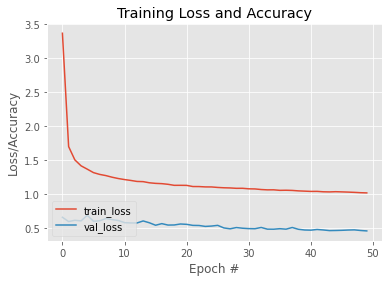

In [23]:
# construct the argument parser and parse the arguments# save the model to disk
print("[INFO] serializing network...")
model.save("/content/hand_model.pth", save_format="h5")
# construct a plot that plots and saves the training history
N = np.arange(0, 50)
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.figure()
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig("graph")

Visualization

(160, 40)
0,6
(160, 6)
6,12
(160, 6)
12,18
(160, 6)
18,24
(160, 6)
24,30
(160, 6)
30,36
(160, 6)


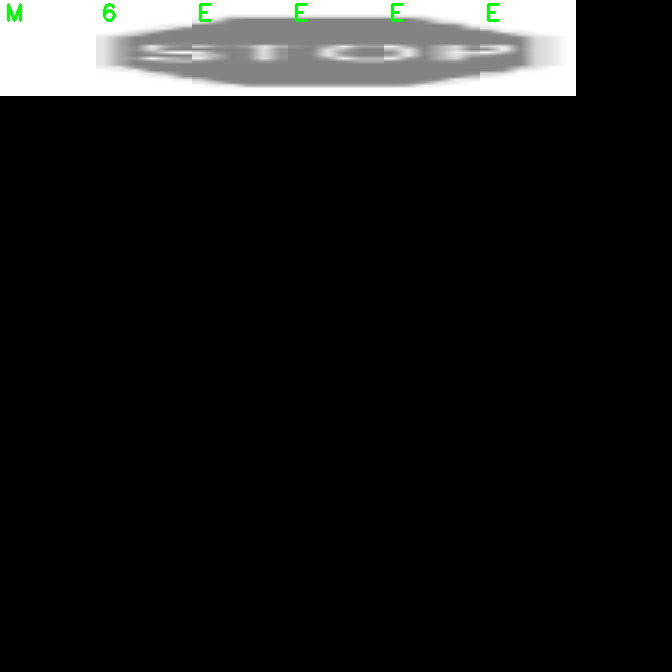

In [60]:
from google.colab.patches import cv2_imshow
images = []
#Read images
crop1=0
crop2=0
img=cv2.imread("/content/6.PNG",0)
img=img*255
#img = (255-img)
img=cv2.resize(img,(40,160),interpolation=cv2.INTER_AREA)
print(img.shape)
div=6
w=img.shape[1]
step=int(w/div)
testX=np.zeros((div,32,32))
for s in range(0,div):
  crop1=crop2
  crop2=step+step*s
  print(str(crop1)+","+str(crop2))
  c=img[:,crop1:crop2]
  print(c.shape)
  c=cv2.resize(c,(32,32))
  testX[s]=c
# randomly select a few testing characters
for i in range(div):
	# classify the character
	probs = model.predict(testX[np.newaxis, i])
	prediction = probs.argmax(axis=1)
	label = labelNames[prediction[0]]
	# extract the image from the test data and initialize the text
	# label color as green (correct)
	image = (testX[i] * 255).astype("uint8")
	color = (0, 255, 0)
	# # otherwise, the class label prediction is incorrect
	# if prediction[0] != np.argmax(testY[i]):
	# 	color = (0, 0, 255)
	# merge the channels into one image, resize the image from 32x32
	# to 96x96 so we can better see it and then draw the predicted
	# label on the image
	image = cv2.merge([image] * 3)
	image = cv2.resize(image, (96, 96), interpolation=cv2.INTER_LINEAR)
	cv2.putText(image, label, (5, 20), cv2.FONT_HERSHEY_SIMPLEX, 0.75,
		color, 2)
	# add the image to our list of output images
	images.append(image)
# construct the montage for the images
montage = build_montages(images, (96, 96), (7, 7))[0]
# show the output montage
cv2_imshow(montage)
